## Parse input

In [2]:
from PIL import Image
import os
from tqdm import tqdm
from typing import Optional, Any, List

# Define the function to split the image
def split_and_save_image(filename: str, input_image_path: str, output_folder_path: str, save_to_tmp: Optional[bool] = False) -> str:
    """
    Разделяет изображение на части и сохраняет их в указанную директорию.

    Аргументы:
    - filename: Имя файла изображения.
    - input_image_path: Путь к директории с исходным изображением.
    - output_folder_path: Путь к директории, куда будут сохранены части изображения.
    - save_to_tmp: Флаг, указывающий на сохранение во временную папку. По умолчанию False.

    Возвращает:
    - Имя папки, в которую были сохранены части изображения.
    """
    # Open the input image
    with Image.open(os.path.join(input_image_path, filename)) as img:

        # Get the filename and the extension
        #extension = os.path.basename(filename).split('.')[-1]
        extension = "png"

        if save_to_tmp:
            foldername = "tmp"
        else:
            foldername = filename.split('.')[0]

        # Define the size of each individual image, assuming they are of equal height
        # and the last image occupies the whole width of the original image
        width, height = img.size
        single_image_height = height // 2  # Divide by 2 because there are 2 rows
        single_image_width = width // 5  # Divide by 5 for the images in the first row
        
        # Create the output directory
        output_directory = os.path.join(output_folder_path, foldername)
        os.makedirs(output_directory, exist_ok=True)
        
        # Split the images and save them
        for i in range(5):  # For the first row
            left = i * single_image_width
            right = (i + 1) * single_image_width
            box = (left, 0, right, single_image_height)
            part_img = img.crop(box)
            part_img.save(os.path.join(output_directory, f'x_{i+1}.{extension}'))
        
        # Save the last image
        box = (0, single_image_height, width*(2/15), 2 * single_image_height)
        part_img = img.crop(box)
        part_img.save(os.path.join(output_directory, f'y.{extension}'))

        return foldername

## Crop squares

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from PIL import Image, ImageDraw


def open_image_and_visualize(image_path: str, visualize: Optional[bool] = False) -> np.ndarray:
    """
    Открывает изображение по указанному пути и при необходимости визуализирует его.

    Аргументы:
    - image_path: Путь к изображению.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Массив изображения в формате numpy.ndarray.
    """
    im = cv2.imread(image_path)
    if visualize:
        plt.imshow(im)
        plt.colorbar()
        plt.show()
    return im


def make_scalar_product_mask(im: np.ndarray, visualize: Optional[bool] = False) -> np.ndarray:
    """
    Создает маску изображения на основе скалярного произведения и при необходимости визуализирует её.

    Аргументы:
    - im: Исходное изображение в формате numpy.ndarray.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Маску изображения в формате numpy.ndarray.
    """
    image = im/255.
    unit_vector = np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])
    unit_image = image/np.sqrt(np.tile(np.sum(image*image, axis=2), (3,1,1)).transpose(1,2,0))
    new_im = np.sum(unit_image*unit_vector, axis=2) * 255
    if visualize:
        plt.imshow(new_im)
        plt.colorbar()
        plt.show()
    return new_im


def make_binar(im: np.ndarray, threshold: Optional[int] = 240, visualize: Optional[bool] = False) -> np.ndarray:
    """
    Бинаризует изображение по заданному порогу и при необходимости визуализирует его.

    Аргументы:
    - im: Исходное изображение в формате numpy.ndarray.
    - threshold: Порог для бинаризации. По умолчанию 240.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Бинаризованное изображение в формате numpy.ndarray.
    """
    img = deepcopy(im)
    img[img!=img] = 255
    img[img<threshold] = 0
    img[img>=threshold] = 255
    if visualize:
        plt.imshow(img, cmap="gray")
        plt.colorbar()
        plt.show()
    return img


def pad_borders(im: np.ndarray, pad_width: Optional[int] = 3, visualize: Optional[bool] = False) -> np.ndarray:
    """
    Добавляет рамку вокруг изображения и при необходимости визуализирует его.

    Аргументы:
    - im: Исходное изображение в формате numpy.ndarray.
    - pad_width: Ширина рамки. По умолчанию 3.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Изображение с рамкой в формате numpy.ndarray.
    """
    im = np.pad(im, 10, 'linear_ramp', end_values=255)
    if visualize:
        plt.imshow(im, cmap='gray')
        plt.colorbar()
        plt.show()
    return im


def smooth_circle_borders(im: np.ndarray, visualize: Optional[bool] = False) -> np.ndarray:
    """
    Сглаживает границы кругов на изображении и при необходимости визуализирует результат.

    Аргументы:
    - im: Исходное изображение в формате numpy.ndarray.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Изображение с сглаженными границами в формате numpy.ndarray.
    """    
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel, iterations=2)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel, iterations=1)
    if visualize:
        plt.imshow(im, cmap='gray')
        plt.colorbar()
        plt.show()
    return im


def detect_circles(im: np.ndarray, visualize: Optional[bool] = False) -> list:
    """
    Обнаруживает круги на изображении и при необходимости визуализирует результат.

    Аргументы:
    - im: Исходное изображение в формате numpy.ndarray.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Список центров обнаруженных кругов.
    """
    im = np.uint8(im)
    radius_tolerance = 5
    min_radius = 20 - radius_tolerance
    max_radius = 20 + radius_tolerance

    dp = 1.5  # The inverse ratio of the accumulator resolution to the image resolution
    minDist = 25  # Minimum distance between the centers of the detected circles
    param1 = 40  # The higher threshold of the two passed to the Canny edge detector
    param2 = 18  # Accumulator threshold for the circle centers at the detection stage

    # Use HoughCircles to detect circles
    detected_circles = cv2.HoughCircles(
        im, 
        cv2.HOUGH_GRADIENT, 
        dp, 
        minDist, 
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )

    # Convert the circle parameters a, b and r to integers.
    detected_circles_rounded = np.uint16(np.around(detected_circles))
    
    # Visualize the results on the new image
    if visualize:
        output_image_circles = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    centers = []
    # Draw the detected circles
    if detected_circles_rounded is not None:
        for i in detected_circles_rounded[0, :]:
            center = (i[0], i[1])
            centers.append(center)

            if visualize:
                radius = i[2]
                # Draw the outer circle
                cv2.circle(output_image_circles, center, radius, (0, 255, 0), 2)
                # Draw the center of the circle
                cv2.circle(output_image_circles, center, 2, (0, 0, 255), 3)

    if visualize:
        plt.imshow(output_image_circles)
        plt.colorbar()
        plt.show()

    return centers


def substract_padding(centers: list, padding: Optional[int] = 10) -> list:
    """
    Корректирует координаты центров кругов, учитывая добавленную рамку.

    Аргументы:
    - centers: Список кортежей с координатами центров кругов.
    - padding: Ширина добавленной рамки. По умолчанию 10.

    Возвращает:
    - Список скорректированных координат центров кругов.
    """
    new_centers = []
    for c in centers:
        new_centers.append((c[0]-padding, c[1]-padding))
    return new_centers


def sort_centers(centers: list, img_path: str, visualize: Optional[bool] = False) -> list:
    """
    Сортирует центры кругов по их расстоянию до шестой точки и при необходимости визуализирует результат.

    Аргументы:
    - centers: Список кортежей с координатами центров кругов.
    - img_path: Путь к изображению.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Список отсортированных координат центров кругов.
    """
    # Define the coordinates of the 6th point
    sixth_point = (40, 190)

    # Calculate distances from the sixth point to each of the centers
    distances = [np.sqrt((x - sixth_point[0])**2 + (y - sixth_point[1])**2) for x, y in centers]

    # Pair each center with its distance from the sixth point
    center_distances = list(zip(centers, distances))

    # Sort the centers by their distance from the sixth point
    sorted_centers = sorted(center_distances, key=lambda x: x[1])

    # Extract the sorted centers and their order
    sorted_centers_only = [center for center, distance in sorted_centers]

    if visualize:
        # Load the provided image
        img = Image.open(img_path)
        # Convert to RGB to plot color on top of the original image
        img_rgb = img.convert('RGB')
        draw = ImageDraw.Draw(img_rgb)

        # Draw the sixth point
        draw.ellipse((sixth_point[0]-3, sixth_point[1]-3, sixth_point[0]+3, sixth_point[1]+3), fill='blue', outline='blue')

        # Draw the centers, lines, and order
        for num, (x, y) in enumerate(sorted_centers_only):
            # Draw the center
            draw.ellipse((x-3, y-3, x+3, y+3), fill='red', outline='red')
            # Draw line from the center to the sixth point
            draw.line((x, y, sixth_point[0], sixth_point[1]), fill='green', width=1)
            # Annotate the order next to the center
            draw.text((x+5, y), f'{num+1}', fill='purple',)

        plt.imshow(img_rgb)
        plt.colorbar()
        plt.show()

    return sorted_centers_only


def define_corners(center: tuple, radius: Optional[int] = 15) -> tuple:
    """
    Определяет координаты углов квадрата вокруг центра круга с заданным радиусом.

    Аргументы:
    - center: Координаты центра круга.
    - radius: Радиус квадрата. По умолчанию 15.

    Возвращает:
    - Кортеж с координатами углов квадрата.
    """
    left = center[0] - radius
    right = center[0] + radius
    up = center[1] - radius
    down = center[1] + radius
    
    return (left, up, right, down)


def get_last_directory(path: str) -> str:
    """
    Возвращает имя последней директории в указанном пути.

    Аргументы:
    - path: Путь, из которого нужно извлечь имя последней директории.

    Возвращает:
    - Имя последней директории в пути.
    """
    directory_path = os.path.dirname(path)
    return os.path.basename(directory_path)



def crop_squares(image_path: str, squares: list, output_dir: str, visualize: Optional[bool] = False):
    """
    Вырезает квадраты из изображения по заданным координатам и сохраняет их.

    Аргументы:
    - image_path: Путь к изображению.
    - squares: Список кортежей, каждый из которых представляет координаты квадрата.
    - output_dir: Директория для сохранения вырезанных квадратов.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.
    """
    subfoldername = os.path.basename(image_path).split('.')[0]
    foldername = get_last_directory(image_path)
    full_path = os.path.join(output_dir,foldername,subfoldername)
    os.makedirs(full_path, exist_ok=True)

    # Load the image
    img = Image.open(image_path)

    # Convert the image to RGB if it's not already
    if img.mode != 'RGB':
        img = img.convert('RGB')

    if visualize:
        draw = ImageDraw.Draw(img)

    # Draw each square
    for i, (left, up, right, down) in enumerate(squares):
        crop = img.crop((left, up, right, down))
        #crop_path = os.path.join(full_path, f"{i+1}.jpg")
        crop_path = os.path.join(full_path, f"{i+1}.png")
        crop.save(crop_path, quality=95)
    
    if visualize:
        for i, (left, up, right, down) in enumerate(squares):
            # Draw a rectangle for each square
            draw.rectangle([(left, up), (right, down)], outline='yellow', width=2)
        plt.imshow(img)
        plt.colorbar()
        plt.show()

In [51]:
def combine_functions_to_get_centers(image_path: str, visualize: Optional[bool] = False) -> list:
    """
    Комбинирует несколько функций для обработки изображения и получения центров кругов.

    Аргументы:
    - image_path: Путь к изображению.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.

    Возвращает:
    - Список координат центров кругов.
    """
    im = open_image_and_visualize(image_path, visualize=visualize)
    im = make_scalar_product_mask(im, visualize=visualize)
    im = make_binar(im, threshold=240)
    im = pad_borders(im, pad_width=10, visualize=visualize)
    im = smooth_circle_borders(im, visualize=visualize)
    centers = detect_circles(im, visualize=visualize)
    centers = substract_padding(centers, padding=10)
    centers = sort_centers(centers, image_path, visualize=visualize)
    return centers

def save_squares(image_path: str, output_dir: str, centers: list, visualize: Optional[bool] = False):
    """
    Сохраняет квадраты, вырезанные вокруг центров кругов, в указанную директорию.

    Аргументы:
    - image_path: Путь к изображению.
    - output_dir: Директория для сохранения вырезанных квадратов.
    - centers: Список координат центров кругов.
    - visualize: Флаг, определяющий необходимость визуализации. По умолчанию False.
    """
    squares = [define_corners(center, radius=20) for center in centers]
    crop_squares(image_path, squares, output_dir, visualize=visualize)

## Predict image

In [52]:
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

In [4]:
"""# Функция для получения признаков изображения
def get_image_features(image_path, model, preprocess):
    processed_image, original_image = preprocess_image(image_path, preprocess)
    with torch.no_grad():
        image_features = model.encode_image(processed_image.to(device)).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features, original_image"""


def display_comparison(base_image: Any, compare_image: Any, similarity: float, i: int) -> None:
    """
    Отображает сравнение базового изображения с изображением для сравнения, включая показатель сходства.

    Аргументы:
    - base_image: Изображение для отображения как базовое.
    - compare_image: Изображение для сравнения с базовым.
    - similarity: Показатель сходства между изображениями.
    - i: Индекс изображения для сравнения.

    Возвращает:
    - None
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(base_image)
    plt.title("Base Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(compare_image)
    plt.title(f"Compare to Image {i}\nSimilarity: {similarity.item():.4f}")
    plt.axis('off')

    plt.show()




## Preprocess Y

In [5]:
import easyocr

# Создание объекта reader
reader = easyocr.Reader(['en'], gpu=False,)  # Укажите 'gpu=True', если доступна GPU

# Функция для распознавания текста с изображения
def recognize_digit(image_path: str) -> str:
    """
    Распознает цифру на изображении с использованием EasyOCR.

    Аргументы:
    - image_path: Путь к изображению для распознавания.

    Возвращает:
    - Распознанную цифру в виде строки. В случае отсутствия распознавания возвращает "1".
    """
    result = reader.readtext(image_path, detail=1, paragraph=False, allowlist='12345LlIiAa!')
    #print("result:", result)
    if not result:
    #if not
        print("None is replaced with 1")
        return "1"
    for detection in result:
        bbox, text, confidence = detection
        #print(text, type(text), type(text[0]))
        print("TEXT:", text, type(text), text[0], type(text[0]))
        if text[0] in "Aa":
            print(f"{text[0]} is replaced with 4")
            return "4"
        if text[0] in "LlIi!":
            print(f"{text[0]} is replaced with 1")
            return "1"
        return text[0]

Using CPU. Note: This module is much faster with a GPU.


In [6]:
def save_bottom_half(input_folder: str, output_folder: str) -> None:
    """
    Вырезает и сохраняет нижнюю половину изображения 'y.jpg' из входной папки в выходную папку под именем 'im.jpg'.

    Аргументы:
    - input_folder: Папка, содержащая исходное изображение 'y.jpg'.
    - output_folder: Папка для сохранения результата.

    Возвращает:
    - None
    """
    # Open the input image
    input_image_path = os.path.join(input_folder, "y.png")
    output_image_path = os.path.join(output_folder, "im.png")

    with Image.open(input_image_path) as img:
        width, height = img.size
        
        # Calculate the box for the bottom half
        # The box is defined by (left, upper, right, lower) edges.
        box = (0, height // 2, width, height)
        
        # Crop the bottom half
        bottom_half = img.crop(box)
        
        # Save the cropped image to the specified output path
        bottom_half.save(output_image_path)

## Get metrics

In [7]:
import json


def find_matching_square(path_to_json: str) -> list:
    """
    Находит координаты прямоугольника, содержащего знак плюс, в JSON файле аннотаций.

    Аргументы:
    - path_to_json: Путь к JSON файлу с аннотациями.

    Возвращает:
    - Координаты прямоугольника, содержащего знак плюс, в формате списка из двух точек.
    """
    
    with open(path_to_json) as json_file:
        data = json.load(json_file)
    # First, let's find the coordinates of all pluses
    plus_signs = [shape['points'][0] for shape in data['shapes'] if shape['label'] == '+']

    # Now, we will check which rectangles contain these plus signs
    # A point is inside a rectangle if its x coordinate is between the x coordinates of the rectangle
    # and its y coordinate is between the y coordinates of the rectangle

    def is_point_in_rect(point, rect):
        # unpack points
        px, py = point
        (rx1, ry1), (rx2, ry2) = rect
        return rx1 <= px <= rx2 and ry1 <= py <= ry2

    # List to store rectangles that contain a plus
    rectangles_with_plus = []

    # Iterate over the shapes to find rectangles that contain a plus
    for shape in data['shapes']:
        if shape['shape_type'] == 'rectangle':
            # Get rectangle coordinates
            rect_coords = shape['points']
            # Check each plus sign
            for plus in plus_signs:
                if is_point_in_rect(plus, rect_coords):
                    return rect_coords

In [8]:
import json
from math import sqrt



def find_point_and_rect(json_file_path: str) -> tuple:
    """
    Находит координаты точки и прямоугольника, соответствующие условиям задачи, основываясь на данных из JSON файла.

    Аргументы:
    - json_file_path: Путь к JSON файлу с аннотациями.

    Возвращает:
    - Кортеж, содержащий координаты точки, номер точки, координаты прямоугольника и смещение прямоугольника по оси X.
    """
    # Загрузка данных из файла
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    # Извлечение специальной цифры из лейблов
    #special_number = int(next(filter(str.isdigit, (shape['label'] for shape in data['shapes']))))
    digit_labels = [(shape['label'], max(point[1] for point in shape['points'])) for shape in data['shapes'] if shape['label'].isdigit()]
    #print("DIGIT LABELS: ", digit_labels)
    special_number, _ = max(digit_labels, key=lambda x: x[1])
    #print("SPECIAL NUMBER: ", special_number)
    ordinary_points = [shape for shape in data['shapes'] if shape['label'] == '+']
    icons = [shape for shape in data['shapes'] if shape['label'] == 'icon']
    point_a = (40, 190)  # Главная точка A
    
    # Вычисление условного расстояния и картиночного номера
    def conditional_distance(point_a, point_b):
        x_b_mod = point_b[0] % 200
        distance = sqrt((x_b_mod - point_a[0]) ** 2 + (point_b[1] - point_a[1]) ** 2)
        return distance

    ordinary_points_info = [{
        'coords': shape['points'][0],
        'distance': conditional_distance(point_a, shape['points'][0]),
        'picture_number': int(shape['points'][0][0] // 200) + 1
    } for shape in ordinary_points]

    ordinary_points_info.sort(key=lambda x: x['distance'])
    #print("ORDINARY: ", ordinary_points_info)
    
    for index, point in enumerate(ordinary_points_info, start=1):
        point['length_number'] = index
        
    
    # Находим точку, у которой длинностный номер равен специальной цифре
    #print("SPECIAL NUMBER:", special_number, type(special_number))
    matching_point = next((p for p in ordinary_points_info if p['length_number'] == int(special_number)), None)
    #print("MATCHING POINT", matching_point)
    
    # Проверка и смещение прямоугольника
    def is_point_in_rect(point, rect):
        return rect[0][0] <= point[0] <= rect[1][0] and rect[0][1] <= point[1] <= rect[1][1]

    def find_shift_and_rect(point, icons):
        for icon in icons:
            for shift_x in range(0, 10001, 200):  # Предполагаем, что смещение может быть до 10000 пикселей
                shifted_rect = [[x + shift_x, y] for x, y in icon['points']]
                if is_point_in_rect(point, shifted_rect):
                    #print("AAAAAAAA:", shifted_rect, shift_x)
                    #answer = (shifted_rect, shift_x)
                    return shifted_rect, shift_x
        #return answer
        return None, None

    # Находим подходящий прямоугольник и требуемое смещение
    matching_rect, shift_x = find_shift_and_rect(matching_point['coords'], icons)

    return matching_point['coords'], matching_point['length_number'], matching_rect, shift_x


## Make benchmarked dataset

In [9]:
from PIL import Image

def save_correct_answer(rectangle_coords: list, image_path: str, cropped_image_path: str) -> None:
    """
    Вырезает и сохраняет указанный прямоугольник из изображения.

    Аргументы:
    - rectangle_coords: Координаты прямоугольника для вырезки.
    - image_path: Путь к исходному изображению.
    - cropped_image_path: Путь для сохранения вырезанного прямоугольника.

    Возвращает:
    - None
    """
    # Reload the original image
    image = Image.open(image_path)

    # Define the coordinates of the rectangle to be cropped
    #rectangle_coords = [[[77.76795580110496, 47.933701657458556], [123.20441988950277, 95.58011049723757]]]
    top_left_x, top_left_y = rectangle_coords[0]
    bottom_right_x, bottom_right_y = rectangle_coords[1]

    # Crop the image
    cropped_image = image.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

    # Save the cropped image to a file
    cropped_image.save(cropped_image_path)

In [13]:
input_image_path = "data/raw"
output_folder_path = "data/interim/raw"

files = os.listdir(input_image_path)
jpg_files = [file for file in files if file.endswith('.png')]
len(jpg_files)

for file in tqdm(jpg_files):
    foldername = split_and_save_image(file, input_image_path, output_folder_path, save_to_tmp=False)

  0%|          | 0/970 [00:00<?, ?it/s]

100%|██████████| 970/970 [00:22<00:00, 43.78it/s]


In [ ]:
input_image_path = "data/raw"
benchmarked_path = "data/benchmarked"
parsed_path = "data/interim/orbits"


os.makedirs(benchmarked_path, exist_ok=True)

files = os.listdir(input_image_path)
json_files = [file for file in files if file.endswith('.json')]
len(json_files)

for file in tqdm(json_files):
    rectangle_coords = find_matching_square(os.path.join(input_image_path, file))
    #print(square)
    foldername = file.split(".")[0]
    os.makedirs(os.path.join(benchmarked_path, foldername), exist_ok=True)
    try:
        save_correct_answer(rectangle_coords, 
                            image_path=os.path.join(input_image_path, f"{foldername}.png"), 
                            cropped_image_path=os.path.join(benchmarked_path, foldername, "correct.jpg"))

        save_bottom_half(input_folder=os.path.join(parsed_path, foldername),
                        output_folder=os.path.join(benchmarked_path, foldername))
    except:
        print(foldername)

                                 
#for file in tqdm(jpg_files[:5]):

## Pipeline

In [10]:
import os
from tqdm import tqdm

In [60]:
def center_for_answer(centers: list, idx: int, digit: int) -> list:
    """
    Рассчитывает центр для ответа на основе индекса и распознанной цифры.

    Аргументы:
    - centers: Список центров.
    - idx: Индекс выбранного изображения.
    - digit: Распознанная цифра.

    Возвращает:
    - Центр для ответа в виде списка координат.
    """
    width = 200
    center = list(centers[digit-1])
    center[0] = center[0] + (idx-1) * width
    return center


def is_point_in_rectangle(point: tuple, rectangle: tuple) -> bool:
    """
    Проверяет, находится ли точка внутри заданного прямоугольника.

    Аргументы:
    - point: Координаты точки (x, y).
    - rectangle: Координаты прямоугольника ((x1, y1), (x2, y2)).

    Возвращает:
    - True, если точка находится внутри прямоугольника, иначе False.
    """
    x, y = point
    x1, y1 = rectangle[0]
    x2, y2 = rectangle[1]
    
    if (x >= x1 and x <= x2) and (y >= y1 and y <= y2):
        return True
    else:
        return False

## Test samples

In [61]:
import torch
import numpy as np
import clip
import torch
from torch import nn
from PIL import Image

# Загрузка предварительно обученной модели CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

class CLIPFineTuneModel(nn.Module):
    """
    Класс для настройки модели CLIP с добавлением линейного слоя для финетюнинга.

    Атрибуты:
    - clip_model (torch.nn.Module): предобученная модель CLIP.
    - linear (torch.nn.Linear): линейный слой для трансформации признаков.
    - cosine_similarity (torch.nn.CosineSimilarity): слой для вычисления косинусного сходства между векторами признаков.

    Методы:
    - forward(img1, img2): Проход вперед, который принимает пары изображений и возвращает оценку их сходства.
    """
    def __init__(self, clip_model):
        """
        Инициализирует класс с предобученной моделью CLIP и добавляет линейный слой.

        Параметры:
        - clip_model (torch.nn.Module): предобученная модель CLIP.
        """
        super(CLIPFineTuneModel, self).__init__()
        self.clip_model = clip_model
        self.linear = nn.Linear(512, 64)
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, img1, img2):
        """
        Выполняет проход вперед, принимая два изображения и вычисляя их сходство.

        Параметры:
        - img1 (torch.Tensor): тензор первого изображения.
        - img2 (torch.Tensor): тензор второго изображения.

        Выходные данные:
        - similarity (torch.Tensor): тензор с оценками сходства изображений.
        """
        with torch.no_grad():
            features1 = self.clip_model.encode_image(img1).to(dtype=torch.float32)
            features2 = self.clip_model.encode_image(img2).to(dtype=torch.float32)

        transformed_features1 = self.linear(features1).to(dtype=torch.float32)
        transformed_features2 = self.linear(features2).to(dtype=torch.float32)
        transformed_features1 = transformed_features1 / transformed_features1.norm(dim=-1, keepdim=True)
        transformed_features2 = transformed_features2 / transformed_features2.norm(dim=-1, keepdim=True)

        similarity = self.cosine_similarity(transformed_features1, transformed_features2).unsqueeze(-1).to(dtype=torch.float32)

        return similarity

In [76]:
# Инициализация модели надстройки
finetune_model = CLIPFineTuneModel(model).to(device)

# Путь к сохраненной модели
model_path = 'finetuned_clip_model_roc099.pth'

# Загрузка весов в модель
#finetune_model.load_state_dict(torch.load(model_path))
finetune_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
finetune_model.eval()  # Переключение модели в режим оценки

CLIPFineTuneModel(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicall

In [66]:
def compare_images(base_image_folder: str, compare_image_folder: str, digit: int, finetune_model, preprocess, visualize: bool = False) -> int:
    """
    Функция для сравнения изображений и определения наиболее похожего.
    
    :param base_image_folder: Путь к папке с базовым изображением.
    :param compare_image_folder: Путь к папке с изображениями для сравнения.
    :param digit: Цифра для определения номера сравниваемого изображения.
    :param finetune_model: Модель для сравнения изображений.
    :param preprocess: Функция предварительной обработки изображений.
    :param visualize: Флаг для визуализации процесса сравнения (по умолчанию False).
    
    :return: Индекс наиболее похожего изображения.
    """
    base_image_path = os.path.join(base_image_folder, "im.png")
    #base_features, base_image = get_image_features(base_image_path, clip_model, preprocess)
    base_image_raw = Image.open(base_image_path).convert("RGB")
    base_image = preprocess(base_image_raw).unsqueeze(0).to(device)

    max_similarity = -1
    max_similarity_index = -1

    for i in range(1, 6):
        compare_image_path = os.path.join(compare_image_folder, f"x_{i}", f"{digit}.png")   #jpg")
        compare_image_raw = Image.open(compare_image_path).convert("RGB").resize((300, 300))
        compare_image = preprocess(compare_image_raw).unsqueeze(0).to(device)
        try:
            #compare_features, compare_image = get_image_features(compare_image_path, clip_model, preprocess)
            # Использование модели надстройки для сравнения
            similarity = finetune_model(base_image, compare_image) #base_features, compare_features).cpu().numpy()
            if similarity > max_similarity:
                max_similarity = similarity
                max_similarity_index = i
            if visualize:
                display_comparison(base_image_raw, compare_image_raw, similarity, i)
        except FileNotFoundError:
            print(f"Файл {compare_image_path} не найден.")

    return max_similarity_index

In [67]:
def median(values: List[float]) -> Optional[float]:
    """
    Вычисляет медиану списка значений.

    Аргументы:
    - values: Список значений.

    Возвращает:
    - Медианное значение списка. Возвращает None, если список пуст.
    """
    sorted_values = sorted(values)
    n = len(sorted_values)
    if n == 0:
        return None
    if n % 2 == 1:
        return sorted_values[n // 2]
    else:
        return (sorted_values[n // 2 - 1] + sorted_values[n // 2]) / 2

def calculate_median_coordinates(list_of_lists: List[List[tuple]]) -> List[tuple]:
    """
    Вычисляет медианные координаты для списка списков координат.

    Аргументы:
    - list_of_lists: Список списков координат.

    Возвращает:
    - Список медианных координат.
    """
    median_coordinates = []
    for i in range(5):  # Предполагаем, что требуется 5 пар координат
        x_values = []
        y_values = []
        for lst in list_of_lists:
            if i < len(lst):  # Убедимся, что индекс не выходит за пределы списка
                x_values.append(lst[i][0])
                y_values.append(lst[i][1])
        median_x = median(x_values)
        median_y = median(y_values)
        if median_x and median_y:
            median_coordinates.append((median_x, median_y))
    return median_coordinates

In [80]:
from typing import Optional, Any, List

In [97]:
def calculate_metrics(input_image_path: str = "data/raw",
                      output_folder_path: str = "data/interim/orbits",
                      output_for_objects_path: str = "data/interim/objects",
                      path_to_chosen_files: Optional[str] = None) -> None:
    """
    Вычисляет метрики для набора изображений.

    Аргументы:
    - input_image_path: Путь к входным изображениям.
    - output_folder_path: Путь к промежуточным результатам.
    - output_for_objects_path: Путь к обработанным объектам.
    - path_to_chosen_files: Путь к файлу со списком выбранных файлов для обработки.

    Возвращает:
    - None
    """

    is_correct = []
    files = os.listdir(input_image_path)

    if path_to_chosen_files:
        with open(path_to_chosen_files, 'r') as file:
            valid_names = file.read().split("\n")
            jpg_files = [file for file in files if file.split('.')[0] in valid_names and file.endswith('.jpg')]
            #print(valid_names)
    else:
        jpg_files = [file for file in files if file.endswith('.jpg')]
    errors = []
    error_answers = []
    #for file in tqdm(jpg_files[50:70]):
    for file in tqdm(errs[:5]):
        try:
            foldername = split_and_save_image(file, input_image_path, output_folder_path, save_to_tmp=True)
            name_without_format = file.split(".")[0]
            digit = recognize_digit(os.path.join(output_folder_path, foldername, "y.png"))
            save_bottom_half(input_folder=os.path.join(output_folder_path, foldername),
                            output_folder=os.path.join(output_for_objects_path, foldername))
            list_of_centers = []
            for i in range(1, 6):
                image_path = os.path.join(output_folder_path, foldername, f"x_{i}.png")
                centers = combine_functions_to_get_centers(image_path, visualize=False)
                list_of_centers.append(centers)

            centers = calculate_median_coordinates(list_of_centers)
            for i in range(1, 6):
                image_path = os.path.join(output_folder_path, foldername, f"x_{i}.png")
                save_squares(image_path, output_for_objects_path, centers, visualize=False)        

            idx = compare_images(base_image_folder=os.path.join(output_for_objects_path, foldername), 
                                compare_image_folder=os.path.join(output_for_objects_path, foldername), 
                                digit=digit, 
                                finetune_model=finetune_model, 
                                preprocess=preprocess,
                                visualize=True)        
            #centers = calculate_median_coordinates(list_of_centers)

        
            
            #print("LIST OF CENTERS:", list_of_centers)
            #print("CENTERS: ", centers)
            #print("IDX:", idx, "DIGIT:", digit)
            matching_point, number, correct_square, shift_x = find_point_and_rect(json_file_path=os.path.join(input_image_path, f"{name_without_format}.json"))
            answer =  center_for_answer(centers, idx, int(digit))
            #print("ANSWER:", answer, "correct_square:", correct_square, "shift_x:", shift_x)
            is_ok = int(is_point_in_rectangle(point=answer, rectangle=correct_square))
            
            if not is_ok:
                errors.append(file)
                error_answers.append(answer)
                print(file)
            is_correct.append(is_ok)
            #print(file)
            #print(answer, correct_square, is_point_in_rectangle(point=answer, rectangle=correct_square))
        except:
            is_correct.append(0)
            print("SOME ERROR:", file)
        
    print(f"Number of evaluated samples: {len(is_correct)}")
    print(f"Accuracy: {sum(is_correct)/len(is_correct)}")
    print(is_correct)
    return errors, error_answers

In [98]:
len(errs)

9

  0%|          | 0/5 [00:00<?, ?it/s]

TEXT: 2 <class 'str'> 2 <class 'str'>


C:\Users\Грязев Артём\AppData\Local\Temp\ipykernel_29048\3151621831.py:20: RuntimeWarning: invalid value encountered in divide
  unit_image = image/np.sqrt(np.tile(np.sum(image*image, axis=2), (3,1,1)).transpose(1,2,0))


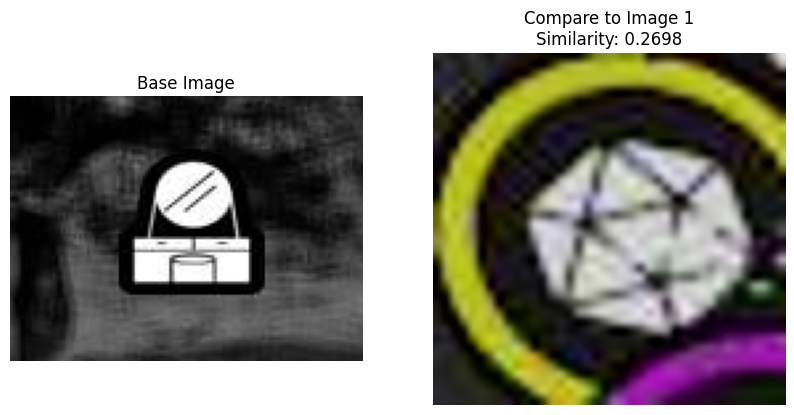

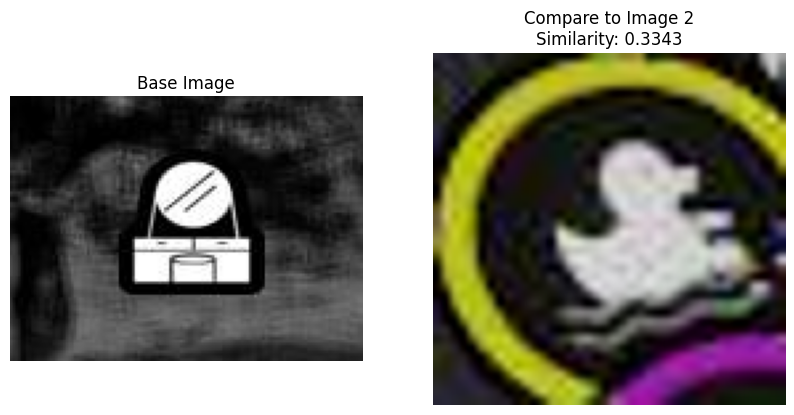

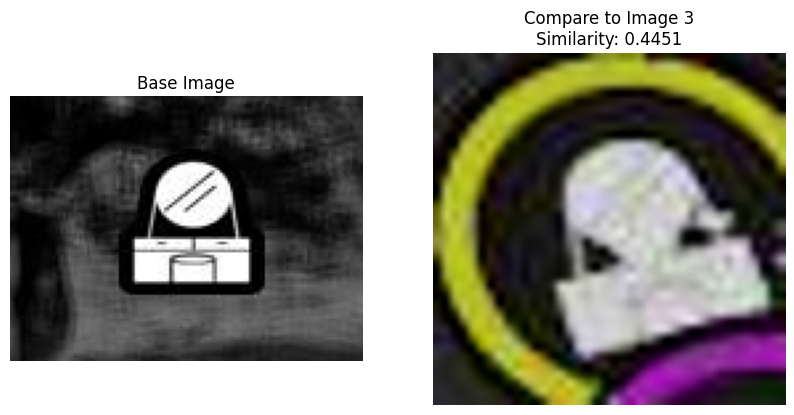

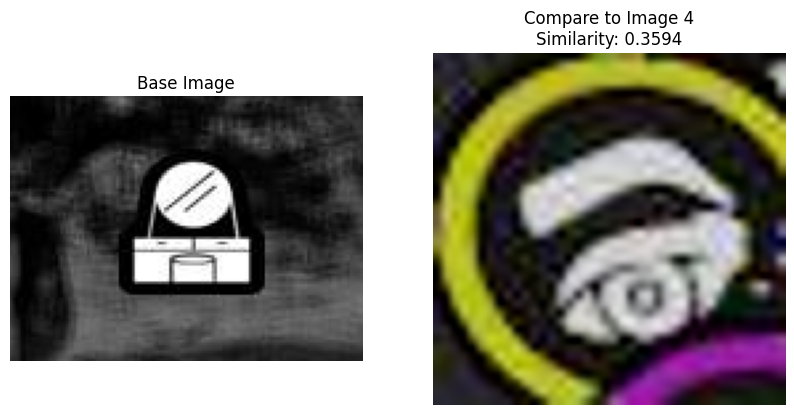

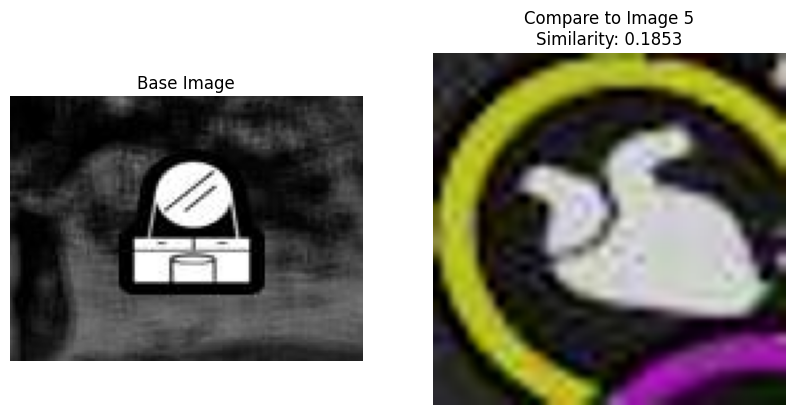

 20%|██        | 1/5 [00:06<00:25,  6.35s/it]

185097.jpg
None is replaced with 1


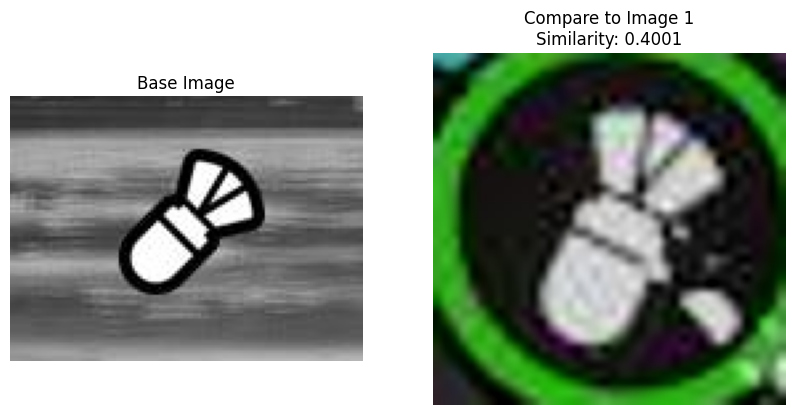

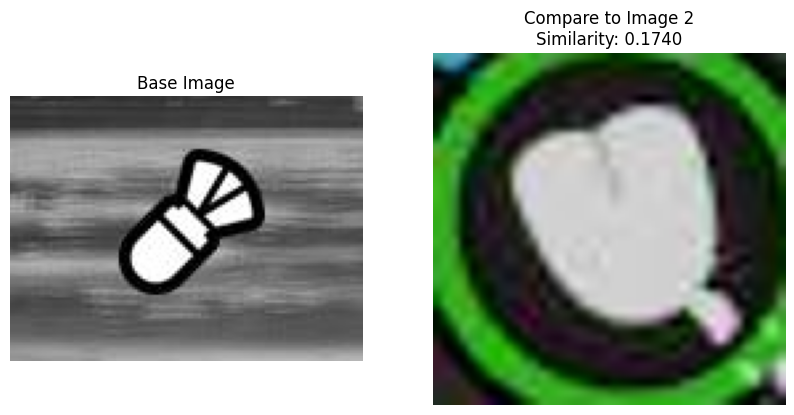

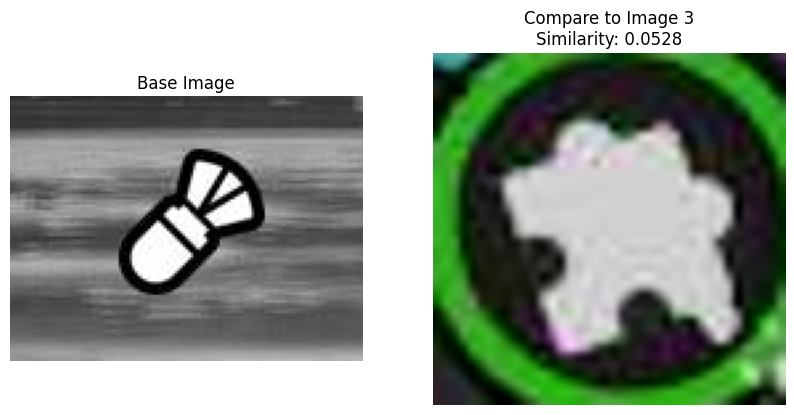

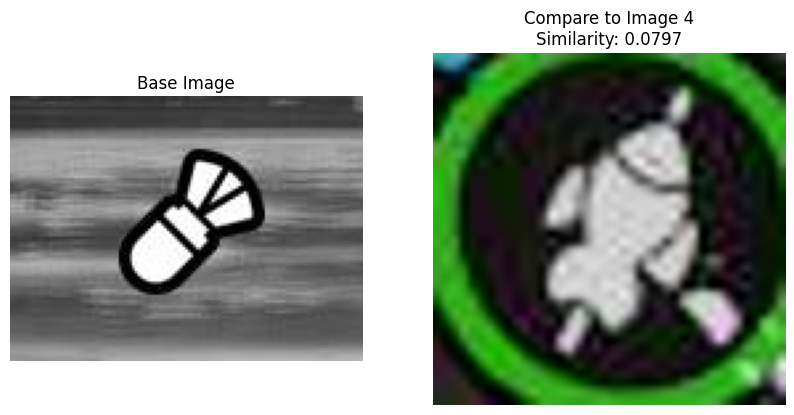

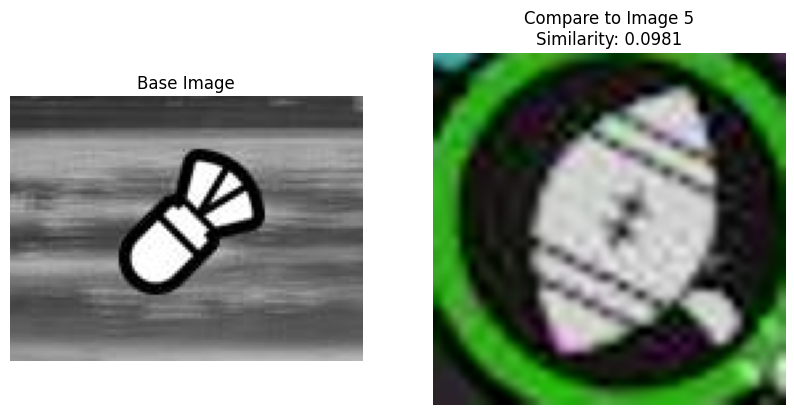

 40%|████      | 2/5 [00:12<00:18,  6.01s/it]

185141.jpg
TEXT: 4 <class 'str'> 4 <class 'str'>


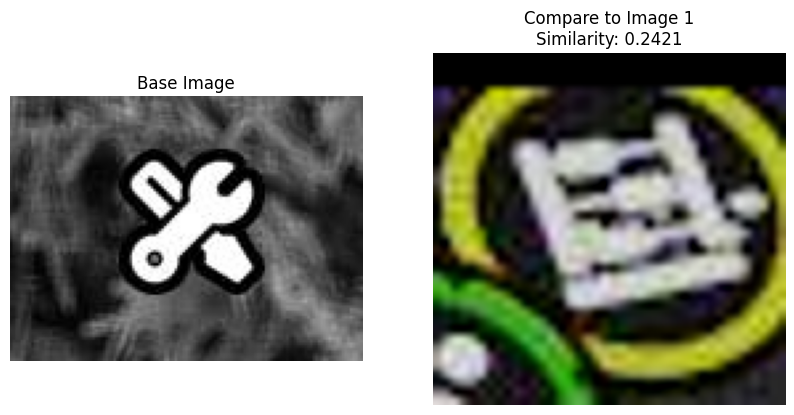

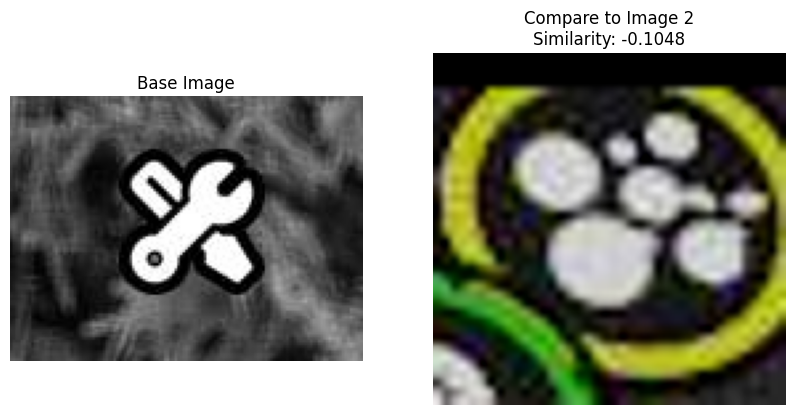

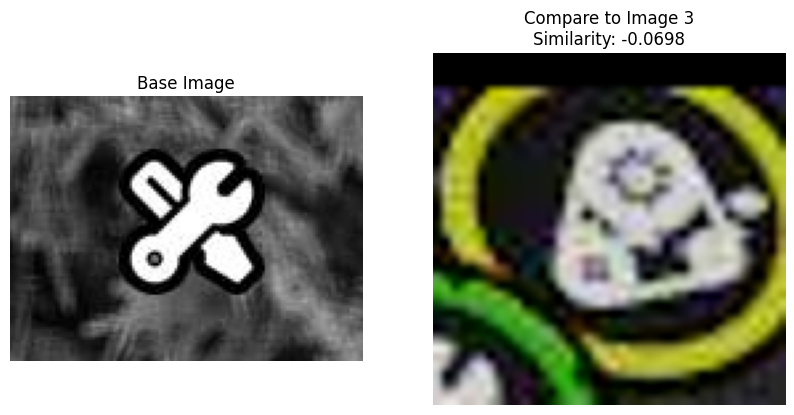

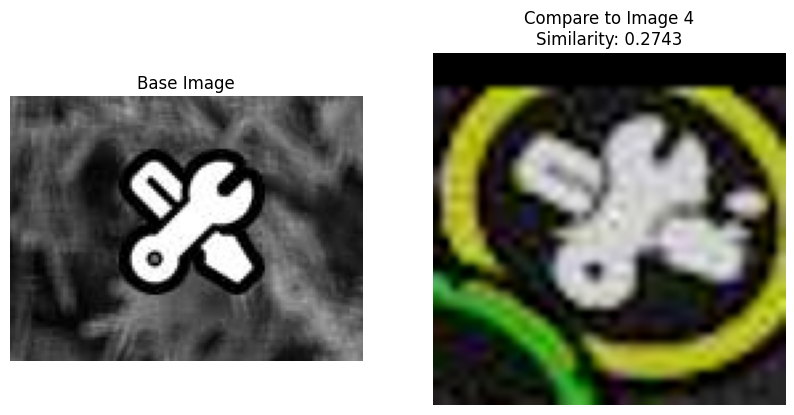

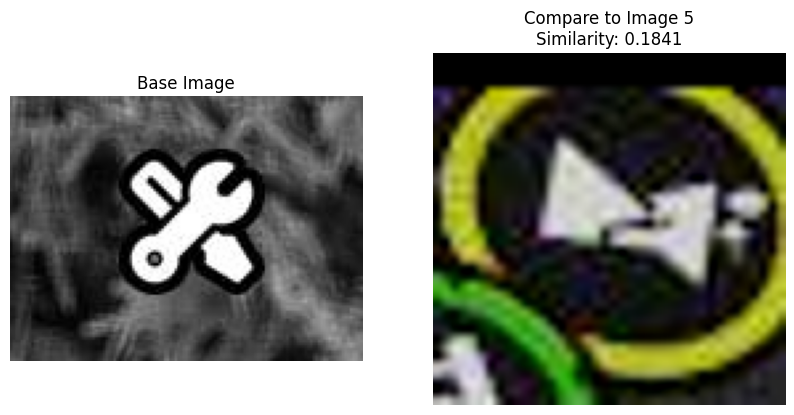

 60%|██████    | 3/5 [00:19<00:13,  6.71s/it]

185242.jpg
TEXT: 1 <class 'str'> 1 <class 'str'>


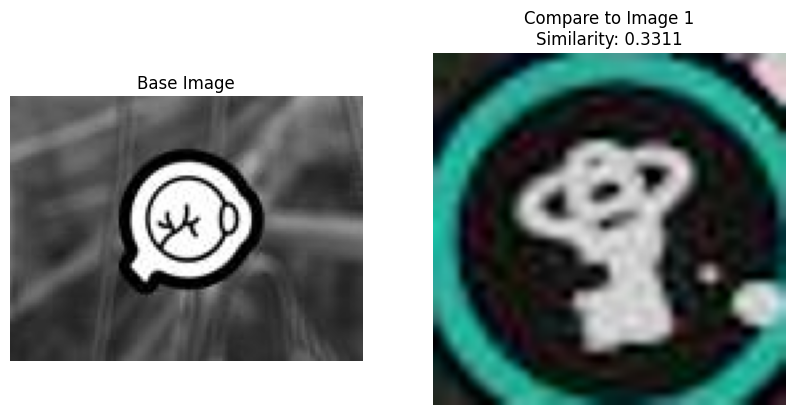

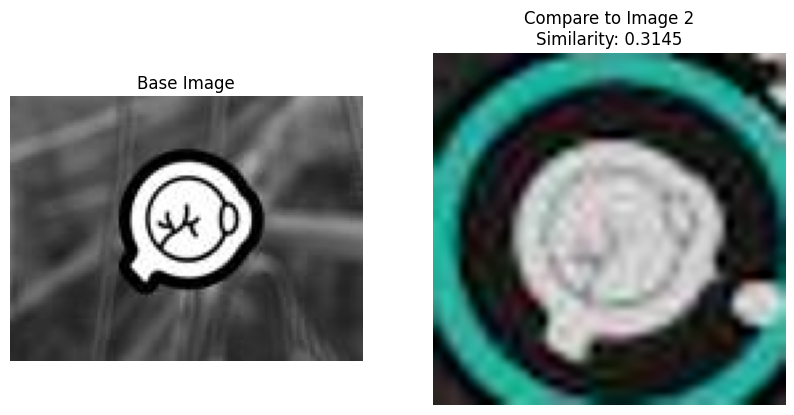

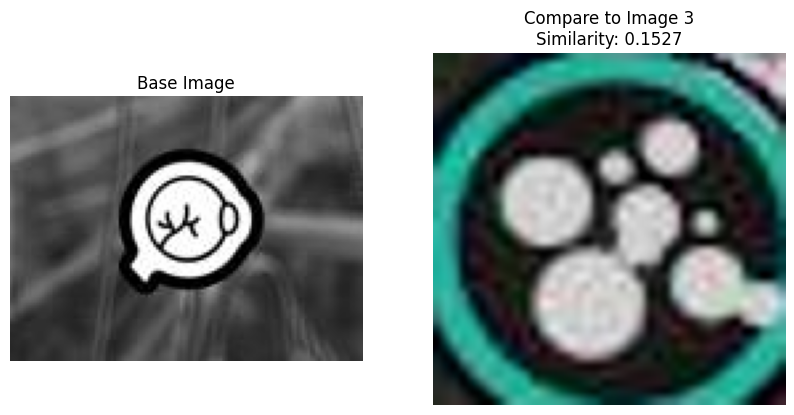

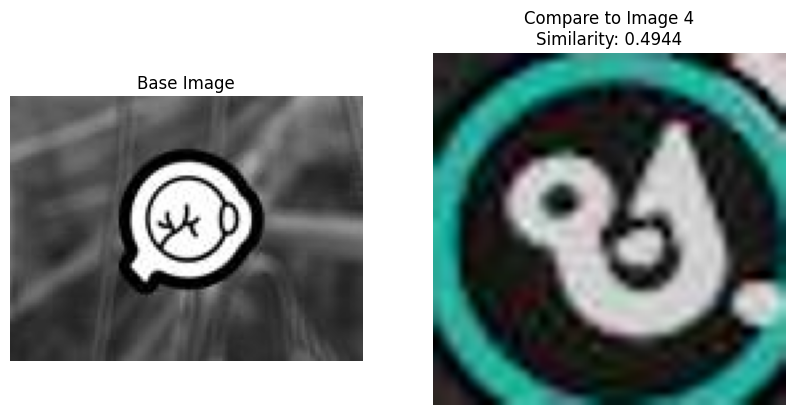

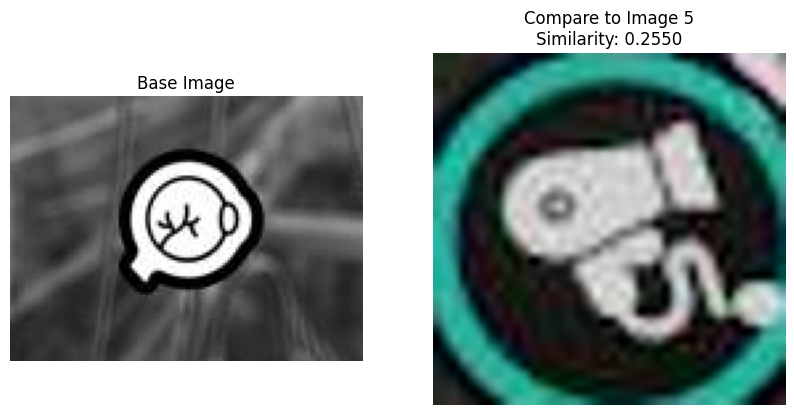

 80%|████████  | 4/5 [00:26<00:06,  6.89s/it]

185245.jpg
TEXT: 4 <class 'str'> 4 <class 'str'>


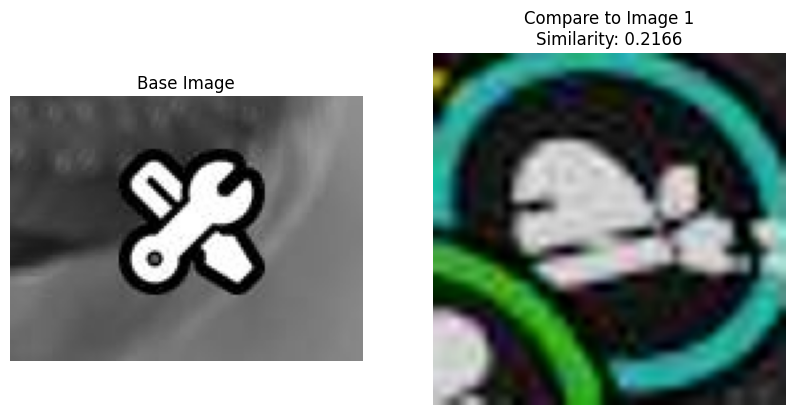

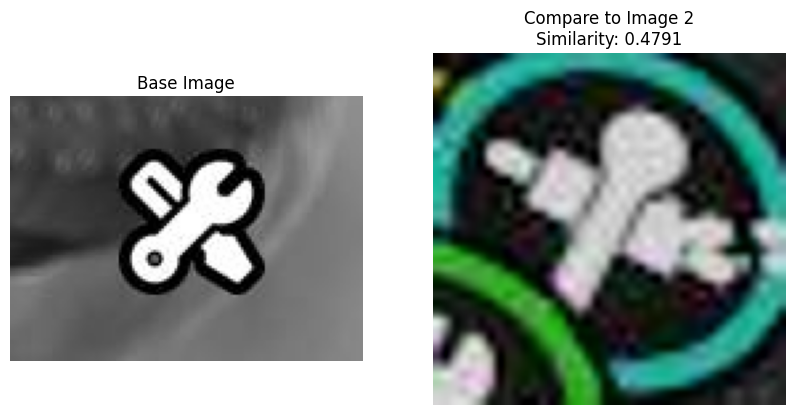

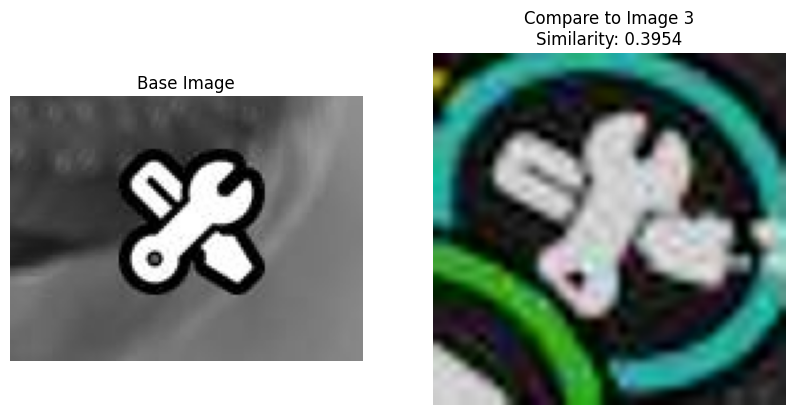

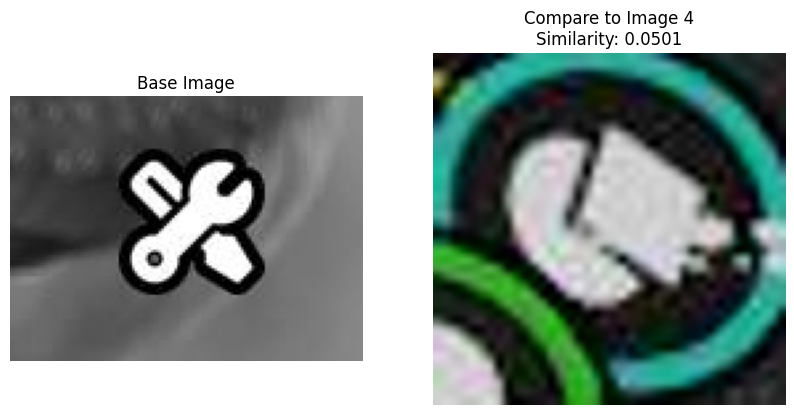

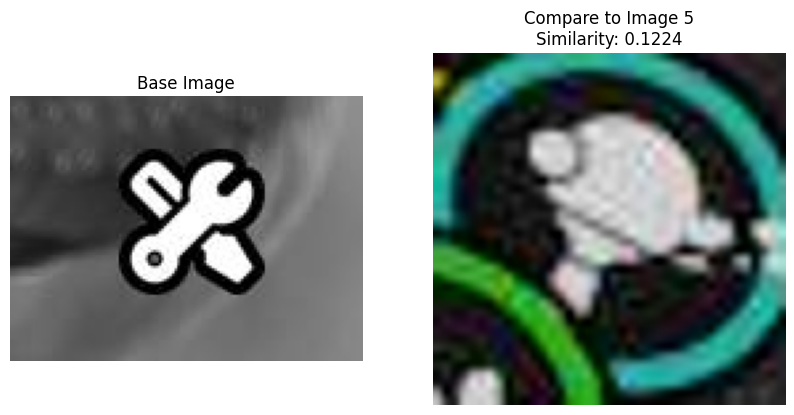

100%|██████████| 5/5 [00:36<00:00,  7.33s/it]

185352.jpg
Number of evaluated samples: 5
Accuracy: 0.0
[0, 0, 0, 0, 0]


(['185097.jpg', '185141.jpg', '185242.jpg', '185245.jpg', '185352.jpg'],
 [[476, 66], [96, 135], [694, 16], [673, 121], [309, 46]])

In [99]:
#errs, err_ans = 
calculate_metrics(path_to_chosen_files="test_files.txt",
input_image_path="data/train")

In [19]:
print(errors)

['183135.jpg', '183415.jpg', '183487.jpg', '183535.jpg', '183610.jpg', '183770.jpg', '184018.jpg', '184537.jpg', '184640.jpg', '184849.jpg', '185003.jpg', '185020.jpg', '185141.jpg', '185242.jpg', '185245.jpg', '185352.jpg', '185453.jpg', '185492.jpg', '185536.jpg', '185588.jpg', '185771.jpg', '185851.jpg', '185894.jpg', '186064.jpg', '186350.jpg', '186414.jpg', '186507.jpg']


In [24]:
print(err_ans)

[[948, 22], [136, 117], [906, 144], [126, 114], [959, 60], [756, 58], [282, 37], [905, 142], [966, 27], [673, 96], [912, 106], [670, 94], [96, 132], [70, 37], [672, 123], [309, 42], [875, 87], [487, 15], [93, 99], [293, 39], [879, 96], [687, 129], [911, 108], [666, 120], [159.0, 46.5], [562, 66], [699, 96]]


In [211]:
errors = ["186507.jpg", "186414.jpg", "186350.jpg"]

In [193]:
calculate_metrics(path_to_chosen_files="test_files.txt")

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Грязев Артём\AppData\Local\Temp\ipykernel_26452\432008763.py:20: RuntimeWarning: invalid value encountered in divide
  unit_image = image/np.sqrt(np.tile(np.sum(image*image, axis=2), (3,1,1)).transpose(1,2,0))
 33%|███▎      | 1/3 [00:02<00:05,  2.72s/it]

IDX: 4 DIGIT: 2
DIGIT LABELS:  [('1', 136.09467455621302), ('2', 110.05917159763314), ('3', 79.88165680473372), ('4', 55.02958579881656), ('5', 22.485207100591715), ('2', 289.4230769230769)]
SPECIAL NUMBER:  1
ORDINARY:  [{'coords': [880.7692307692307, 126.4957264957265], 'distance': 75.46471315005684, 'picture_number': 5}, {'coords': [97.86324786324786, 104.27350427350427], 'distance': 103.42720881290643, 'picture_number': 1}, {'coords': [323.5042735042735, 81.1965811965812], 'distance': 137.15373723230678, 'picture_number': 2}, {'coords': [471.3675213675214, 42.73504273504274], 'distance': 150.56855260973853, 'picture_number': 3}, {'coords': [718.3760683760684, 19.65811965811966], 'distance': 187.50777128561265, 'picture_number': 4}]
SPECIAL NUMBER: 1
MATCHING POINT {'coords': [880.7692307692307, 126.4957264957265], 'distance': 75.46471315005684, 'picture_number': 5, 'length_number': 1}
AAAAAAAA: [[874.0384615384615, 77.24358974358974], [924.3589743589744, 126.92307692307692]] 800
AA

 67%|██████▋   | 2/3 [00:04<00:02,  2.32s/it]

IDX: 4 DIGIT: 4
DIGIT LABELS:  [('1', 136.09467455621302), ('2', 110.05917159763314), ('3', 79.88165680473372), ('4', 55.02958579881656), ('5', 22.485207100591715), ('4', 277.4580335731415)]
SPECIAL NUMBER:  1
ORDINARY:  [{'coords': [72.22222222222223, 123.93162393162393], 'distance': 73.5071555785601, 'picture_number': 1}, {'coords': [315.8119658119658, 111.11111111111111], 'distance': 109.41165820148295, 'picture_number': 2}, {'coords': [532.9059829059829, 88.88888888888889], 'distance': 137.3134314255173, 'picture_number': 3}, {'coords': [714.1025641025641, 48.71794871794873], 'distance': 159.53622792657092, 'picture_number': 4}, {'coords': [887.6068376068376, 16.23931623931624], 'distance': 180.16433111996437, 'picture_number': 5}]
SPECIAL NUMBER: 1
MATCHING POINT {'coords': [72.22222222222223, 123.93162393162393], 'distance': 73.5071555785601, 'picture_number': 1, 'length_number': 1}
AAAAAAAA: [[45.563549160671464, 97.12230215827338], [96.40287769784173, 147.4820143884892]] 0
ANSW

100%|██████████| 3/3 [00:06<00:00,  2.27s/it]

IDX: 3 DIGIT: 4
DIGIT LABELS:  [('1', 136.09467455621302), ('2', 110.05917159763314), ('3', 79.88165680473372), ('4', 55.02958579881656), ('5', 22.485207100591715), ('4', 276.6025641025641)]
SPECIAL NUMBER:  1
ORDINARY:  [{'coords': [888.4615384615385, 128.2051282051282], 'distance': 78.53105685143815, 'picture_number': 5}, {'coords': [135.47008547008548, 124.7863247863248], 'distance': 115.61730257422607, 'picture_number': 1}, {'coords': [280.7692307692308, 70.08547008547009], 'distance': 126.65553545793993, 'picture_number': 2}, {'coords': [494.44444444444446, 46.15384615384616], 'distance': 153.8047902608874, 'picture_number': 3}, {'coords': [708.1196581196581, 17.948717948717956], 'distance': 185.04575509270379, 'picture_number': 4}]
SPECIAL NUMBER: 1
MATCHING POINT {'coords': [888.4615384615385, 128.2051282051282], 'distance': 78.53105685143815, 'picture_number': 5, 'length_number': 1}
AAAAAAAA: [[860.8974358974359, 101.92307692307692], [911.2179487179487, 152.8846153846154]] 800


In [70]:
errors = ["183135.jpg", "183225.jpg", "183255.jpg", "183257.jpg", "183415.jpg", "183474.jpg", "183487.jpg"]

In [29]:
jpg_files[:5]

['183099.jpg', '183103.jpg', '183108.jpg', '183118.jpg', '183121.jpg']

In [3]:
# Define the paths
input_image_path = 'orbits/train'
output_folder_path = 'orbits/parsed_input'

#
filenames = ["183199.jpg", "183201.jpg", "183203.jpg", "183205.jpg", 
"183208.jpg", "183218.jpg", "183220.jpg"]
filenames = ["183125.jpg", "183108.jpg", "183239.jpg"]

# Call the function
for filename in tqdm(filenames):
    split_and_save_image(filename, input_image_path, output_folder_path, save_to_tmp=True)

100%|██████████| 3/3 [00:00<00:00, 42.13it/s]
